In [1]:
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
import csv
import random
import scipy.integrate as it

In [2]:
#def ricker(f=25, length=0.08, dt=0.004):
def ricker(f=15, length=0.120, dt=0.004):
    t0 = np.arange(-length/2, (length+dt)/2, dt)
    g = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, list(g)

In [3]:
t0,w=ricker()

In [4]:
fname1="Scaled_Wavelet.csv"
f1=pd.read_csv(fname1)
wav_ini=np.array(f1[['A']])

In [5]:
wav=np.array([i[0] for i in wav_ini])

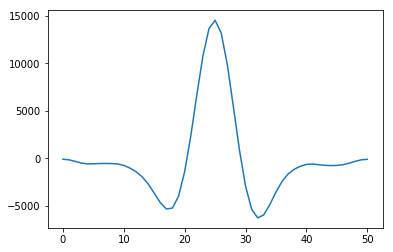

In [6]:
plt.plot (range(len(wav)), wav)

In [7]:
def I_get(r:list(),I0):
    I=list()
    I.append(I0)
    for i in range(len(r)):
        if((1-r[i])!=0.0):
            I.append(I[i]*((1+r[i])/(1-r[i])))
        else:
            I.append(1.0)
    return I

In [8]:
def r_get(I:list()):
    r=list()
    for i in range(len(I)-1):
        if((I[i+1]+I[i])!=0.0):
            r.append((I[i+1]-I[i])/(I[i+1]+I[i]))
        else:
            r.append(0.0)
    return r

In [9]:
class Operator(object):
    

    def __init__(self, wavelet):
         
        self.wavelet= wavelet
         
        
    def forward(self, r):
         
        return np.convolve(r, self.wavelet, mode ='same') 
                           
    def adjoint(self, r):
         
        return np.correlate(r, self.wavelet, mode ='same') 

In [10]:
F= Operator(wav)

In [11]:
t=np.array(list(range(0,700,4)))

In [12]:
def wedge_I(minVal=300,maxVal=500,time=t):    
    I=list()
    for i in time:
        if i<minVal or i>maxVal:
            I.append(4500.0)
        else:
            I.append(5500.0)
    return np.array(I)

In [13]:
I=wedge_I()

In [14]:
r=np.array(r_get(I))
 

In [15]:
s=F.forward(r)

In [16]:
rn_var=list()
for i in range(100):
    rn_var.append(0.1*rn.normal(0,0.5))

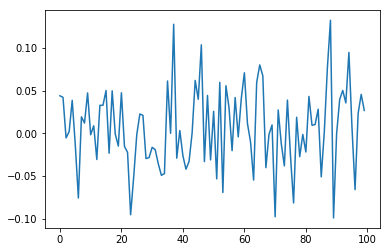

In [17]:
plt.plot(range(len(rn_var)),rn_var)

In [18]:
def wedge(minVal=300,maxVal=500,sampleSize=4):
    I_list=list()
    r_list=list()
    s_list=list()
    while maxVal>=minVal:
        I=wedge_I(minVal,maxVal)
        r=r_get(I)
        s=F.forward(r)*(1+0.2*rn.normal(0,0.5))
        I_list.append(I)
        r_list.append(r)
        s_list.append(s)
        maxVal=maxVal-sampleSize
    return I_list,r_list,s_list

In [19]:
I_list,r_list,s_list=wedge()

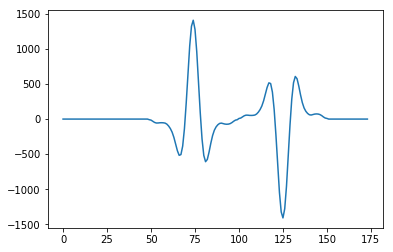

In [20]:
plt.plot(range(len(s_list[0])),s_list[0])

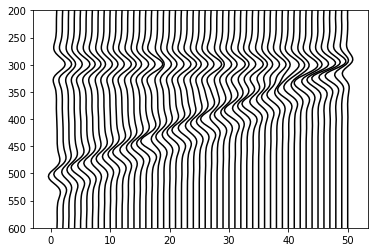

In [21]:
fig,ax = plt.subplots()
#x=np.array(list(range(len(s_list[0]))))
y_res=np.array(s_list)/10000
offsets=[i for i in range(1,51)]
#x=x+offset
#plt.figure(figsize=(15,3))
y=np.linspace(0,700,len(s_list[0]))
for i in range(len(offsets)):
    x=offsets[i]+10*y_res[i]
    #plt.figure(figsize=(15,3))
    ax.plot(x,y,'k')
    #ax.fill_betweenx(y,offsets[i],x,where=(x>offsets[i]),color='k')
ax.set_ylim(600,200)
plt.show()

In [22]:
n=10

In [23]:
r_pred=list()
d_pred=list()
r_pred_integ=list()
t=np.linspace(0,700,len(s_list[0]))
for k in range(len(s_list)):   
    d=s_list[k]
    r_obs=r_list[k]
    m_est = np.zeros_like(d)
    r = d - F.forward(m_est)
    s = np.zeros_like(d)
    beta = 0

    for i in range(n):
        g = F.adjoint(r)
        if i != 0:
            beta = np.dot(g, g) / gamma
        gamma = np.dot(g, g)
        s = g + beta * s
        deltar = F.forward(s)
        alpha = np.dot(g, g) / np.dot(deltar, deltar)
        m_est = m_est + alpha * s
        r = r - alpha * deltar
    d_pred.append(F.forward(m_est))
    r_pred.append(m_est)
    r_pred_integ.append(it.cumtrapz(m_est,t,initial=0))

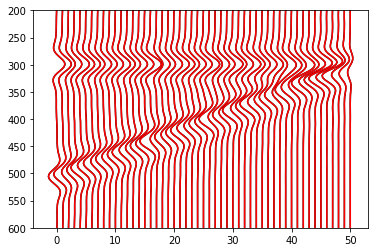

In [24]:
fig,ax = plt.subplots()
y_res_obs=np.array(s_list)/10000
y_res_pred=np.array(d_pred)/10000
offsets=[i for i in range(len(s_list))]
y=np.linspace(0,700,len(s_list[0]))
for i in range(len(offsets)):
    x_obs=offsets[i]+10*y_res_obs[i]
    x_pred=offsets[i]+10*y_res_pred[i]
    ax.plot(x_obs,y,'k')
    ax.plot(x_pred,y,'r')
    #ax.fill_betweenx(y,offsets[i],x_obs,where=(x_obs>offsets[i]),color='k')
    #ax.fill_betweenx(y,offsets[i],x_pred,where=(x_pred>offsets[i]),color='r')
ax.set_ylim(600,200)
plt.show()

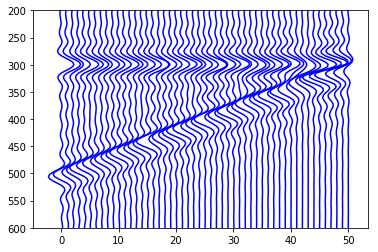

In [25]:
fig,ax = plt.subplots()

y_res_obs=np.array(r_list)
y_res_pred=10*np.array(r_pred)
offsets=[i for i in range(len(s_list))]
y=np.linspace(0,700,len(s_list[0]))
for i in range(len(offsets)):
    x_obs=offsets[i]+10*y_res_obs[i]
    x_pred=offsets[i]+10*y_res_pred[i]
    #ax.plot(x_obs,y,'k')
    ax.plot(x_pred,y,'b')
    #ax.fill_betweenx(y,offsets[i],x_obs,where=(x_obs>offsets[i]),color='k')
    #ax.fill_betweenx(y,offsets[i],x_pred,where=(x_pred>offsets[i]),color='b')
ax.set_ylim(600,200)
plt.show()

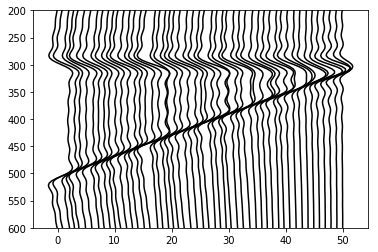

In [26]:
fig,ax = plt.subplots()
#x=np.array(list(range(len(s_list[0]))))
y_res=np.array(r_pred_integ)
offsets=[i for i in range(1,len(s_list))]
#x=x+offset
#plt.figure(figsize=(15,3))
y=np.linspace(0,700,len(s_list[0]))
for i in range(len(offsets)):
    x=offsets[i]+10*y_res[i]
    #plt.figure(figsize=(15,3))
    ax.plot(x,y,'k')
    #ax.fill_betweenx(y,offsets[i],x,where=(x>offsets[i]),color='k')
ax.set_ylim(600,200)
plt.show()

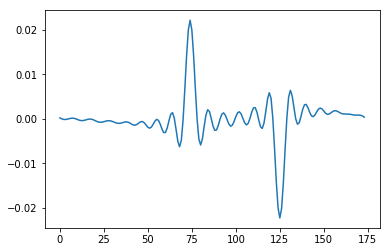

In [27]:
r_ind=0
plt.plot(range(len(r_pred[0])),r_pred[r_ind])

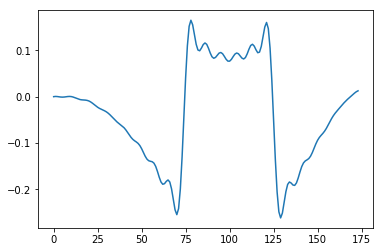

In [28]:
plt.plot(range(len(r_pred_integ[0])),r_pred_integ[0])

In [29]:
i_val=74
s_draft=list()
r_draft=list()
r_integ_draft=list()
for i in range(len(s_list)):
    s_draft.append(s_list[i][i_val])
    r_draft.append(r_pred[i][i_val])
    r_integ_draft.append(r_pred[i][i_val])

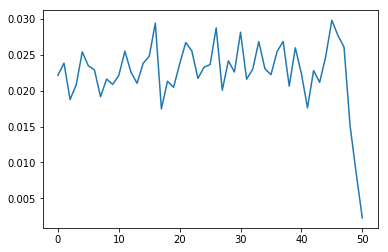

In [30]:
plt.plot(range(len(r_draft)),r_draft)

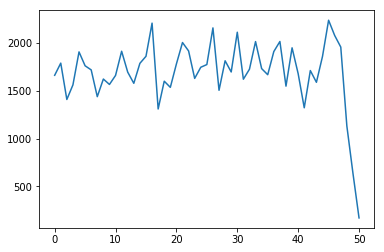

In [31]:
plt.plot(range(len(r_integ_draft)),75000*np.array(r_integ_draft))

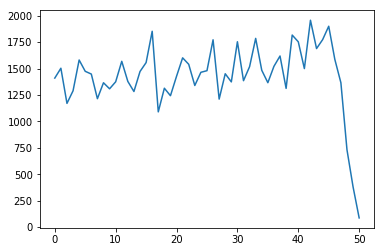

In [32]:
plt.plot(range(len(s_draft)),s_draft)

plt.plot(range(len(s_draft)),s_draft)
plt.plot(range(len(r_integ_draft)),70000*np.array(r_integ_draft))
plt.plot(range(len(r_draft)),70000*np.array(r_draft))

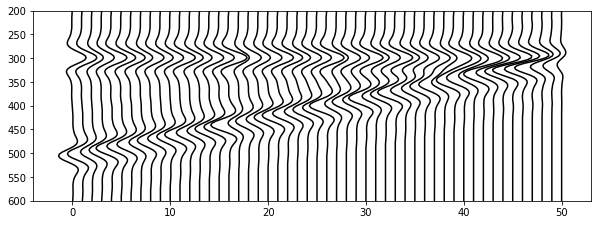

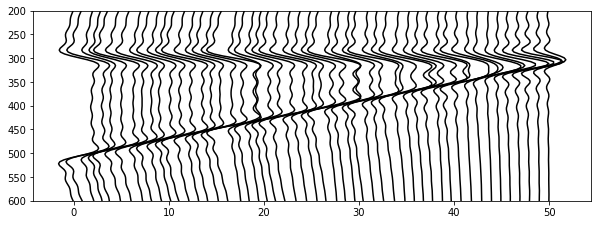

In [33]:
fig,ax = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(10)
y_res_obs=np.array(s_list)/10000
offsets=[i for i in range(len(s_list))]
y=np.linspace(0,700,len(s_list[0]))
for i in range(len(offsets)):
    x_obs=offsets[i]+10*y_res_obs[i]
    ax.plot(x_obs,y,'k')
    #ax.fill_betweenx(y,offsets[i],x_obs,where=(x_obs>offsets[i]),color='k')
    #ax.fill_betweenx(y,offsets[i],x_pred,where=(x_pred>offsets[i]),color='r')
ax.set_ylim(600,200)
plt.show()
fig,ax = plt.subplots()
fig.set_figheight(3.5)
fig.set_figwidth(10)
#x=np.array(list(range(len(s_list[0]))))
y_res=np.array(r_pred_integ)
offsets=[i for i in range(1,len(s_list))]
#x=x+offset
#plt.figure(figsize=(15,3))
y=np.linspace(0,700,len(s_list[0]))
for i in range(len(offsets)):
    x=offsets[i]+10*y_res[i]
    #plt.figure(figsize=(15,3))
    ax.plot(x,y,'k')
    #ax.fill_betweenx(y,offsets[i],x,where=(x>offsets[i]),color='k')
ax.set_ylim(600,200)
plt.show()